In [2]:
import pandas as pd

from geopy.distance import geodesic  

from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [4]:

file_path = '2022_OCELOT_deployement_summary.xlsx' 

df = pd.read_excel(file_path)

file_id = df['File'].to_numpy()
latitude  = df['Latitude'].to_numpy()
longitude = df['Longitude'].to_numpy()

surrounding_stations = {}

for i, fid in enumerate(file_id):
    center_coord = (latitude[i], longitude[i])
    neighbors = []

    for j, other_fid in enumerate(file_id):
        if i == j:
            continue  # skip self
        other_coord = (latitude[j], longitude[j])
        dist_km = geodesic(center_coord, other_coord).kilometers

        if dist_km <= 0.4:  # 0.4 km
            neighbors.append((other_fid, latitude[j], longitude[j], dist_km))

    surrounding_stations[fid] = neighbors

station_id = 5
station = file_id[station_id]

print(f"Neighbors of {station}:")
for neighbor in surrounding_stations[station]:
    print(f"  ID: {neighbor[0]}, Lat: {neighbor[1]}, Lon: {neighbor[2]}, Distance: {neighbor[3]:.2f} km")

Neighbors of 453000063:
  ID: 453000080, Lat: 33.409954212544, Lon: -110.784231801251, Distance: 0.35 km
  ID: 453000288, Lat: 33.409969098667, Lon: -110.778851695203, Distance: 0.35 km
  ID: 453000365, Lat: 33.405456436996, Lon: -110.784225309598, Distance: 0.36 km
  ID: 453005576, Lat: 33.405339306013, Lon: -110.781470699994, Distance: 0.26 km
  ID: 453010612, Lat: 33.40996958117, Lon: -110.781550532539, Distance: 0.25 km
  ID: 453010754, Lat: 33.407697414289, Lon: -110.778861737174, Distance: 0.25 km
  ID: 453010788, Lat: 33.407739237999, Lon: -110.784302029609, Distance: 0.26 km


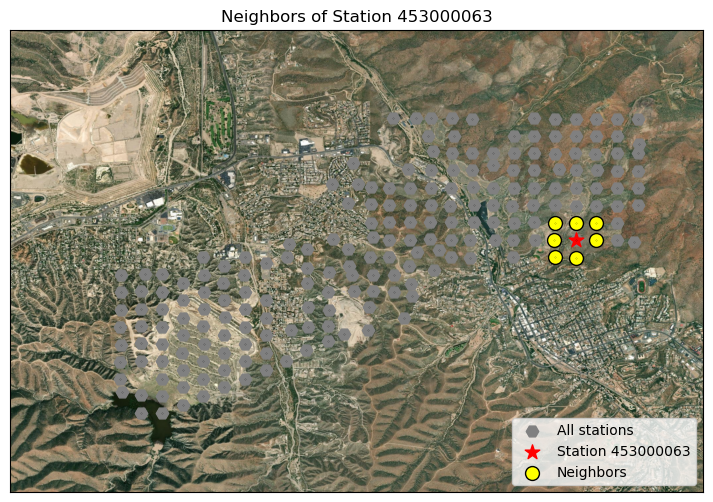

In [5]:
mpl.rcParams['figure.figsize'] = [12, 6]

station_id = 5
station = file_id[station_id]
station_lat = latitude[station_id]
station_lon = longitude[station_id]
neighbors = surrounding_stations[station]

neighbor_lats = [n[1] for n in neighbors]
neighbor_lons = [n[2] for n in neighbors]

# Plotting
m = Basemap(resolution='i', projection='cyl',
            llcrnrlat=33.375, urcrnrlat=33.435,
            llcrnrlon=-110.855, urcrnrlon=-110.765)

m.arcgisimage(service='World_Imagery', xpixels=2000, dpi=300, verbose=False)
m.drawstates()

m.scatter(longitude, latitude, s=80, marker='H', color='gray',  label='All stations')

m.scatter(station_lon, station_lat, s=120, marker='*', color='red', label=f'Station {station}')

m.scatter(neighbor_lons, neighbor_lats, s=100, marker='o', color='yellow', edgecolor='black', label='Neighbors')

for fid, lat, lon in zip(file_id, latitude, longitude):
    m.plot(lon, lat, 'ko', markersize=0.1)  
   

plt.legend(loc='lower right')
plt.title(f"Neighbors of Station {station}")
plt.show()


In [10]:
file_id[100]

453000321

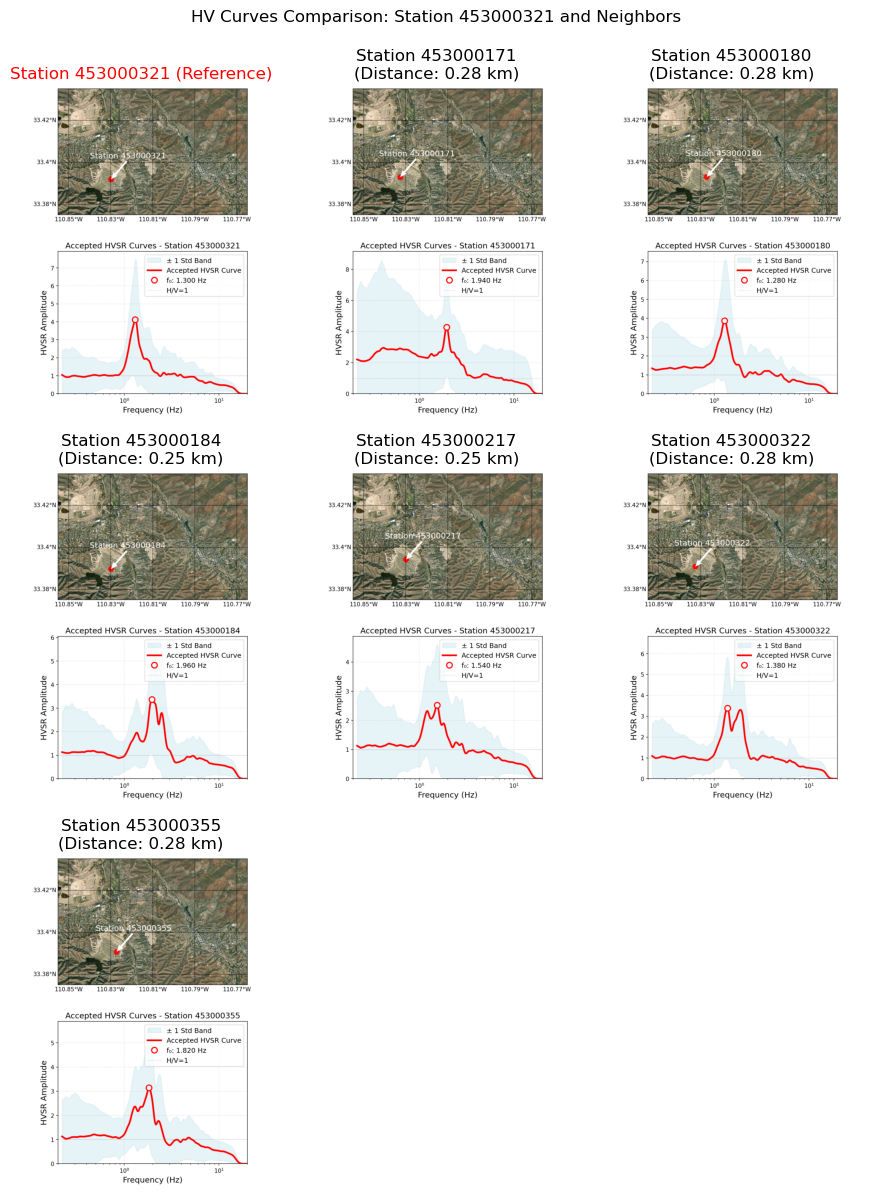

In [19]:
import os
from PIL import Image

# Directory containing HV curve images
hv_dir = "/Users/shihao/Research/CSM/Projects/BHP/BHP_OCELOT/SEISMIC/output_1"

# Reference station (use the same station_id from above)
station_id = 100
station = file_id[station_id]
reference_station = station
neighbors = surrounding_stations[station]

# Collect all station IDs (reference + neighbors)
all_stations = [reference_station] + [n[0] for n in neighbors]

# Filter stations that have HV curve files
available_stations = []
for st in all_stations:
    # Try to find the HV curve file for this station
    hv_file = os.path.join(hv_dir, f"{st}_2022_07_20_to_2022_07_21_hvsr.png")
    if os.path.exists(hv_file):
        available_stations.append((st, hv_file))
    else:
        print(f"Warning: HV curve not found for station {st}")

# Plot all available HV curves
if available_stations:
    n_stations = len(available_stations)
    ncols = min(3, n_stations)  # Maximum 3 columns
    nrows = (n_stations + ncols - 1) // ncols  # Calculate rows needed
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(3*ncols, 4*nrows))
    
    # Handle case where axes is not an array
    if n_stations == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_stations > 1 else axes
    
    for idx, (st, hv_file) in enumerate(available_stations):
        img = Image.open(hv_file)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        
        # Highlight reference station in title
        if st == reference_station:
            axes[idx].set_title(f"Station {st} (Reference)", fontsize=12, color='red')
        else:
            # Find distance for neighbor
            dist = [n[3] for n in neighbors if n[0] == st][0]
            axes[idx].set_title(f"Station {st}\n(Distance: {dist:.2f} km)", fontsize=12)
    
    # Hide extra subplots if any
    for idx in range(n_stations, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f"HV Curves Comparison: Station {reference_station} and Neighbors", 
                 fontsize=12, y=0.995)
    plt.tight_layout()
    plt.show()
else:
    print("No HV curve files found for any of the stations.")
